# The Best Format to Save Pandas Data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
import os

In [3]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
from utils import Timer, MemoryTracker, GC, NotebookStyle

In [5]:
style = NotebookStyle()
style.override({'grid.color': 'lightgray'})

## Random Dataset

In [6]:
def generate_dataset(n_rows, n_cols, max_nan=0.1):
    """Randomly generate datasets with numerical and categorical features.
    
    The numerical features are taken from the normal distribution X ~ N(0, 1).
    
    A max_nan proportion of both numerical and categorical features is replaces
    with NaN values.
    """
    dataset, types = {}, {}
    
    for col in range(n_cols):
        name = f'n{col}'
        values = np.random.normal(0, 1, n_rows)
        nan_cnt = np.random.randint(1, int(max_nan*n_rows))
        index = np.random.choice(n_rows, nan_cnt, replace=False)
        values[index] = np.nan
        dataset[name] = values
        types[name] = 'float32'
    
    return pd.DataFrame(dataset), types

## Benchmarking

In [7]:
def size_of(filename, unit=1024**2):
    return round(os.stat(filename).st_size / unit, 2)

In [8]:
def get_save_load(df, fmt):
    save = getattr(df, f'to_{fmt}')
    load = feather.read_dataframe if fmt == 'feather' else getattr(pd, f'read_{fmt}')
    return save, load

In [9]:
def benchmark(list_of_formats, n_rows=3_000, n_cols=15, n_rounds=20):
    """Runs dataset saving/loading benchamrk using formts from the list_of_formats.
    
    Each round a new random dataset is generated with data_size observations. 
    The measurements for each of the rounds are concatenated together and returned
    as a single data frame.
    
    Parameters:
        list_of_formats: A list of tuples in the format (<format_name>, [<params_dict>]). 
            The <format_name> should be one of the pandas supported formats.
        n_rows: A number of samples in the generated dataset.
        n_cols: A number of numerical columns in the generated dataset.
        n_rounds: A number of randomly generated datasets to test the formats.
            
    """
    runs = []
    
    for i in range(n_rounds):
        print(f'Benchmarking round #{i + 1:d}')
        print('\tgenerating dataset...')
        dataset, _ = generate_dataset(n_rows=n_rows, n_cols=n_cols)
        
        benchmark_res = []
        
        for case in list_of_formats:
            fmt, params = case if len(case) == 2 else (case[0], {})
            
            with GC():
                print('\ttesting format:', fmt)
                filename = f'random.{fmt}'
                save, load = get_save_load(dataset, fmt)
                res = defaultdict(int)
                res['format'] = fmt
                res['filename'] = filename
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        save(filename, **params)
                res['size_mb'] = size_of(filename)
                res['save_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                res['save_time'] = float(timer)
                
                with MemoryTracker() as tracker:
                    with Timer() as timer:
                        _ = load(filename)
                res['load_ram_delta_mb'] = tracker.memory / (1024 ** 2)
                res['load_time'] = float(timer)
                
                benchmark_res.append(res)
                
            run = pd.DataFrame(benchmark_res)
            run['run_no'] = i
            runs.append(run)
            
    benchmark_res_df = pd.concat(runs, axis=0)
    benchmark_res_df.reset_index(inplace=True, drop=True)
    return benchmark_res_df

### Categoricals As Strings (???)

In [10]:
formats = [
    ('hdf', {'key': 'data', 'format': 'table'}),
    ('pickle',),
    ('feather',),
    ('parquet', {'engine': 'pyarrow'})
]

In [11]:
results = benchmark(formats)

Benchmarking round #1
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #2
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #3
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #4
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #5
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #6
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #7
	generating dataset...
	testing format: hdf
	testing format: pickle
	testing format: feather
	testing format: parquet
Benchmarking round #

In [12]:
results.to_feather('one_million_cats_str.feather')

In [13]:
results = feather.read_dataframe('one_million_cats_str.feather')

In [14]:
avg = results.groupby('format').mean().reset_index().drop(columns=['run_no'])
avg

,format,size_mb,save_ram_delta_mb,save_time,load_ram_delta_mb,load_time
0,feather,0.3465,0.0,0.006601,0.0,0.002634
1,hdf,1.0800,0.0,0.021248,0.0,0.007292
2,parquet,0.4005,0.0,0.016967,0.0,0.005085
3,pickle,0.3400,0.0,0.001044,0.0,0.000753


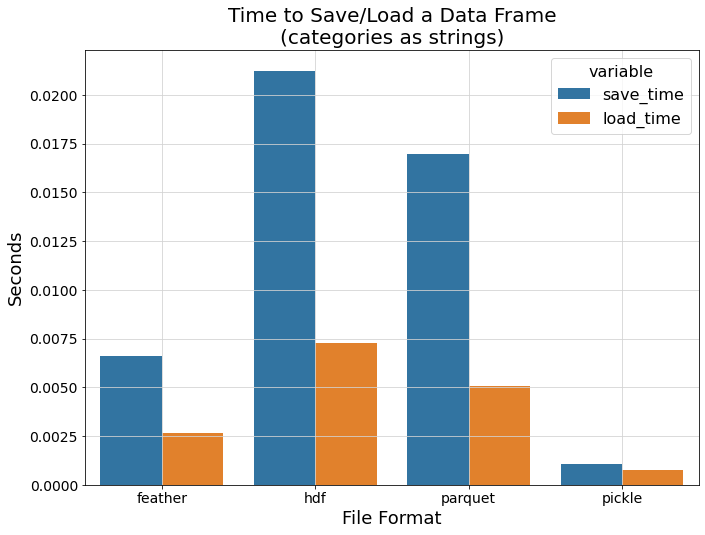

In [15]:
io_speed = avg[['format', 'save_time', 'load_time']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=io_speed)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Seconds')
_ = ax.set_title('Time to Save/Load a Data Frame\n(categories as strings)')
ax.grid(True)

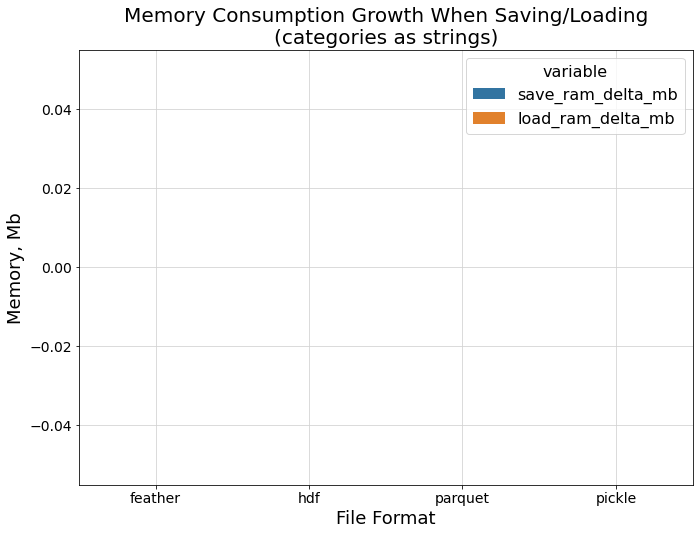

In [16]:
mem_size = avg[['format', 'save_ram_delta_mb', 'load_ram_delta_mb']].melt(id_vars='format')
ax = sns.barplot(x='format', y='value', hue='variable', data=mem_size)
_ = ax.set_xlabel('File Format')
_ = ax.set_ylabel('Memory, Mb')
ax.set_title('Memory Consumption Growth When Saving/Loading\n(categories as strings)')
ax.grid(True)

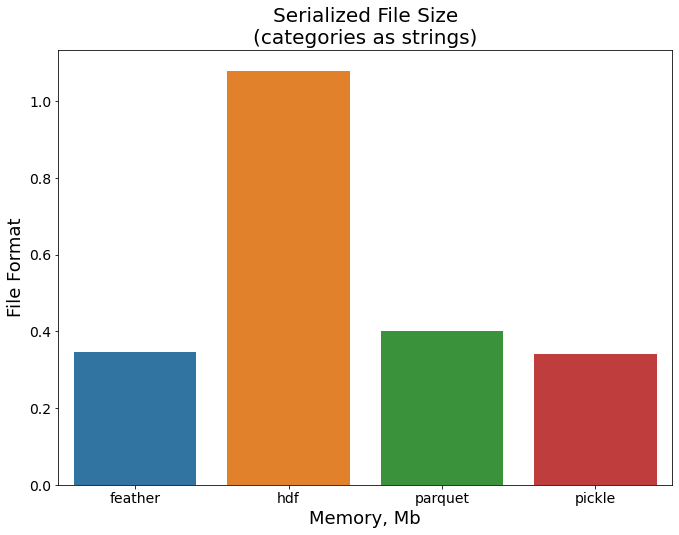

In [17]:
ax = sns.barplot(x='format', y='size_mb', data=avg)
_ = ax.set_xlabel('Memory, Mb')
_ = ax.set_ylabel('File Format')
_ = ax.set_title('Serialized File Size\n(categories as strings)')
